In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
import time
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
import json
from glob import glob
import scipy.stats
import datetime as dt

In [3]:
calib_year = 2015

In [4]:
case_name = 'hillslope-bayes-opt-seanmods'

In [5]:
'''Correlation'''
def nse(predictions, targets):
    return (1-(np.sum((targets-predictions)**2))/np.sum((targets-np.mean(targets))**2))

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

def spearman(x, y):
    res = scipy.stats.spearmanr(x, y).statistic
    return res

In [6]:
'''Import Hillslope Model Results'''
file_dir = '/glade/derecho/scratch/marielj/archive/' + case_name + '/lnd/hist/'
files = glob(file_dir + case_name + '.clm2.h2.*.nc')
colfiles = glob(file_dir + case_name + '.clm2.h3.*.nc')

data = xr.open_mfdataset(files)
coldata = xr.open_mfdataset(colfiles)

In [7]:
data

<xarray.Dataset>
Dimensions:       (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 1, time: 5111,
                   hist_interval: 2, lndgrid: 1)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi        (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 1.0
  * time          (time) object 2004-01-01 00:00:00 ... 2018-01-01 00:00:00
Dimensions without coordinates: hist_interval, lndgrid
Data variables: (12/35)
    mcdate        (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    mcsec         (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    mdcur         (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    mscur         (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    nstep         (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    time_bounds   (time, hist_interval) object dask.array<chunksize=(365, 2), meta=np.ndarray>
    ...            ...
    TSA           (time, lndgrid) float32 dask.array<chunksize=(365, 1), meta=np.ndarray>
    ZWT           (time, lndgrid) float32 dask.array<chunksize=(365, 1), meta=np.ndarray>
    ZWT_PERCH     (time, lndgrid) float32 dask.array<chunksize=(365, 1), meta=np.ndarray>
    TSOI          (time, levgrnd, lndgrid) float32 dask.array<chunksize=(365, 25, 1), meta=np.ndarray>
    H2OSOI        (time, levsoi, lndgrid) float32 dask.array<chunksize=(365, 20, 1), meta=np.ndarray>
    SOILICE       (time, levsoi, lndgrid) float32 dask.array<chunksize=(365, 20, 1), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 07/26/24 08:40:18
    source:                               Community Terrestrial Systems Model
    hostname:                             derecho
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     day_1

In [8]:
'''Load calibration WTE data'''
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in theA metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

# Pull out calib year
wte = dt1[dt1.DATE.dt.year == calib_year]
wte = wte[wte.PEATLAND == 'S2'].reset_index(drop = True)

# Pull out all data
wte_all = dt1[(dt1.DATE.dt.year > 2011) & (dt1.DATE.dt.year < 2018)]
wte_all = wte_all[wte_all.PEATLAND == 'S2'].reset_index(drop = True)

In [9]:
'''Load calibration streamflow data'''
dt2 =pd.read_csv('./rawdata/Streamflow_daily.csv', 
                 parse_dates=['Date'])

# Coerce the data into the types specified in the metadata  
dt2.Watershed = dt2.Watershed.astype('category') 

# Pull out 2017 year
stream = dt2[dt2.Date.dt.year == calib_year]
stream = stream[stream.Watershed == 'S2'].reset_index(drop = True)

#Convert cm/day to mm/sec
m = 10/(60*60*24)
stream['Flow_mms'] = m*stream['Flow (cm/day)']

# Pull out all data
stream_all = dt2[(dt2.Date.dt.year > 2011) & (dt2.Date.dt.year < 2018)]
stream_all = stream_all[stream_all.Watershed == 'S2'].reset_index(drop = True)
stream_all['Flow_mms'] = m*stream_all['Flow (cm/day)']

In [10]:
'''Load Upland Water Table Elevation'''
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/570/3/76b573566f4d40753727c58cb01a6bc9".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows=1, sep="," ,
                 names=["WATERSHED", "WELL_ID", "DATE", "WTE"],
                 parse_dates=['DATE'],
                 na_values={'WTE':['NA'],})

infile2  ="https://pasta.lternet.edu/package/data/eml/edi/570/3/2a3060e49654ea9dac8c1246a73faeb0".strip() 
infile2  = infile2.replace("https://","http://")


uplandwte = dt1[(dt1.DATE.dt.year > 2011) & (dt1.DATE.dt.year < 2018)]
uplandwte = uplandwte[uplandwte.WATERSHED == 'S2'].reset_index(drop = True)

In [11]:
'''Convert WTE to WTD'''
bog_elev = 422.06
lagg_elev = 421.64
upland_elev = 425.9

#Convert bog water tables
wte['WTD'] = -(bog_elev - wte.WTE)
wte_all['WTD'] = -(bog_elev - wte_all.WTE)

(0.0, 0.0005)

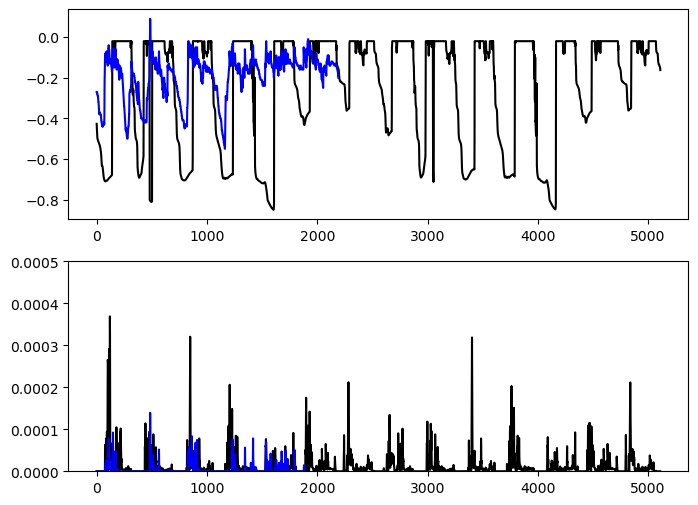

In [12]:
'''General Model Plot'''
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (8, 6))

#Plot CLM hillslope - column level
ax1.plot(-coldata.sel(column = 1).ZWT, color = 'black', label = 'Hillslope')
ax1.plot(wte_all.WTD, color = 'blue', label ='MEF')

#Plot CLM hillslope - runoff
ax2.plot(data.QRUNOFF, color = 'black')
ax2.plot(stream_all.Flow_mms, color = 'blue')

ax2.set_ylim(0, 5e-4)

In [13]:
#Separate out columns
obsWTE = wte[~((wte['DATE'].dt.month == 2) &(wte['DATE'].dt.day == 29))]['WTD']
Lagg = coldata.sel(column = 0).sel(time = slice("2011-01-01", "2018-01-01"))
Bog = coldata.sel(column = 1).sel(time = slice("2011-01-01", "2018-01-01"))
Upland = coldata.sel(column = 2).sel(time = slice("2011-01-01", "2018-01-01"))

### Water Table Comparison

In [14]:
meas_wt = wte.WTD
mod_wt = -Bog.ZWT[(Bog.time.dt.year == calib_year)]

In [15]:
rsquared(meas_wt, mod_wt)

0.22535999844737706

In [16]:
nse(mod_wt, meas_wt)

-6.469207183010139

In [17]:
spearman(mod_wt, meas_wt)

0.17596350838113545

### Streamflow comparison

In [18]:
meas_stream = stream.Flow_mms
mod_stream = data.QRUNOFF[(data.time.dt.year == calib_year)].values.reshape(365)

In [19]:
rsquared(meas_stream, mod_stream)

0.26147596224475805

In [20]:
nse(mod_stream, meas_stream)

-0.28868821064606953

In [21]:
spearman(mod_stream, meas_stream)

0.5528348922866484

## All data comparison

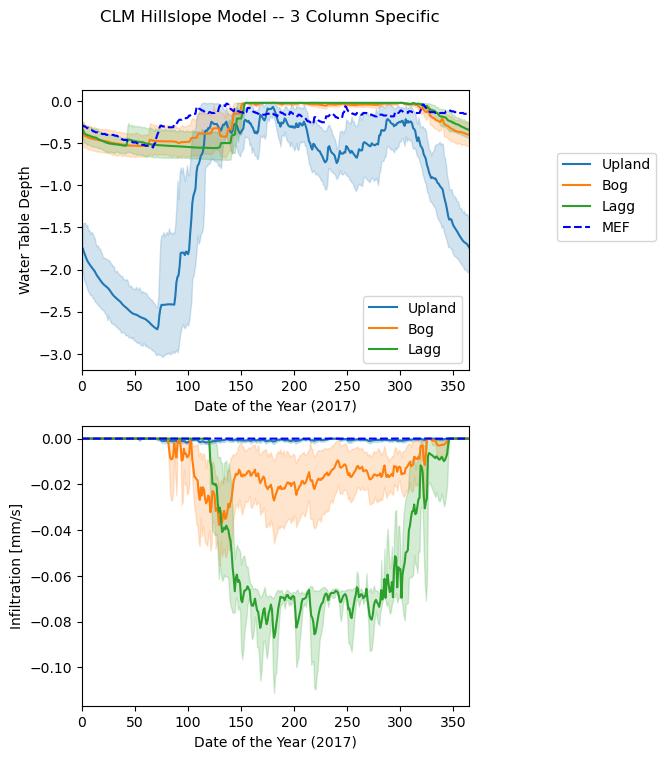

In [22]:
'''Plot model results'''
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (5, 8))

#Plot CLM hillslope - column level
sns.lineplot(x = Upland.time.dt.dayofyear, y = -Upland.ZWT, label = 'Upland', ax = ax1)
sns.lineplot(x = Bog.time.dt.dayofyear, y = -Bog.ZWT, label = 'Bog', ax = ax1)
sns.lineplot(x = Lagg.time.dt.dayofyear, y = -Lagg.ZWT, label = 'Lagg', ax = ax1)

#Plot Marcell data 
ax1.plot(wte.WTD, color = 'blue', linestyle = '--', label ='MEF')

#Plot spcifics
ax1.set_xlabel('Date of the Year (2017)')
ax1.set_ylabel('Water Table Depth')
ax1.set_xlim(0, 365)

#Plot CLM hillslope - column level
sns.lineplot(x = Upland.time.dt.dayofyear, y = -Upland.QINFL, label = 'Upland', ax = ax2)
sns.lineplot(x = Bog.time.dt.dayofyear, y = -Bog.QINFL, label = 'Bog', ax = ax2)
sns.lineplot(x = Lagg.time.dt.dayofyear, y = -Lagg.QINFL, label = 'Lagg', ax = ax2)

#Plot Marcell data 
ax2.plot(stream['Flow_mms'], color = 'blue', linestyle='--', label ='MEF')

#Plot spcifics
ax2.set_xlabel('Date of the Year (2017)')
ax2.set_ylabel('Infiltration [mm/s]')
ax2.set_xlim(0, 365)

plt.suptitle('CLM Hillslope Model -- 3 Column Specific')
plt.legend(bbox_to_anchor=(1.5, 2))
plt.show()

(0.0, 365.0)

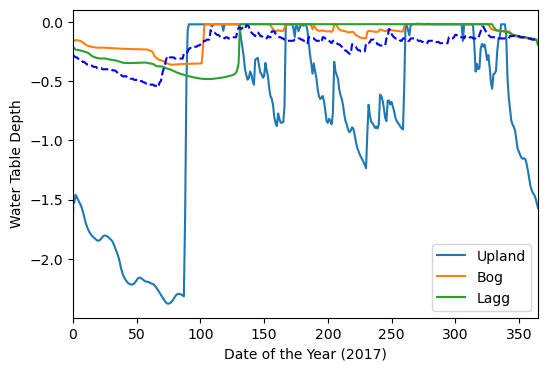

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 4))

#Plot CLM hillslope - column level
sns.lineplot(x = Upland.sel(time = slice("2017-01-01", "2018-01-01")).time.dt.dayofyear,
             y = -Upland.sel(time = slice("2017-01-01", "2018-01-01")).ZWT, label = 'Upland', ax = ax1)
sns.lineplot(x = Bog.sel(time = slice("2017-01-01", "2018-01-01")).time.dt.dayofyear,
             y = -Bog.sel(time = slice("2017-01-01", "2018-01-01")).ZWT, label = 'Bog', ax = ax1)
sns.lineplot(x = Lagg.sel(time = slice("2017-01-01", "2018-01-01")).time.dt.dayofyear,
             y = -Lagg.sel(time = slice("2017-01-01", "2018-01-01")).ZWT, label = 'Lagg', ax = ax1)

#Plot Marcell data 
ax1.plot(wte.WTD, color = 'blue', linestyle = '--', label ='MEF')

#Plot spcifics
ax1.set_xlabel('Date of the Year (2017)')
ax1.set_ylabel('Water Table Depth')
ax1.set_xlim(0, 365)

(0.0, 365.0)

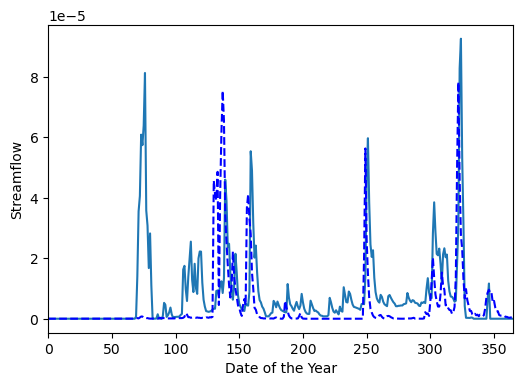

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 4))

#Plot CLM hillslope - column level
sns.lineplot(x = data.sel(time = slice("2015-01-01", "2016-01-01")).time.dt.dayofyear, y = data.sel(time = slice("2015-01-01", "2016-01-01")).QRUNOFF.values.ravel(), ax = ax1)

#Plot Marcell data 
ax1.plot(stream.Flow_mms, color = 'blue', linestyle = '--', label ='MEF')

#Plot spcifics
ax1.set_xlabel('Date of the Year')
ax1.set_ylabel('Streamflow')
ax1.set_xlim(0, 365)

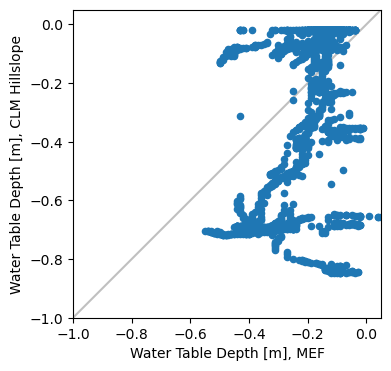

In [25]:
'''Plot model correlation'''
#Remove leap years
obsWTE = wte_all[~((wte_all['DATE'].dt.month == 2) &(wte_all['DATE'].dt.day == 29))].WTD
modWTE = Bog.ZWT[(Bog.time.dt.year < 2018) & (Bog.time.dt.year > 2011)]
#plot
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

ax.axline([0, 0], [2, 2], color = 'silver')
ax.scatter(obsWTE, -modWTE, s = 20, zorder = 2)
ax.set_xlabel('Water Table Depth [m], MEF')
ax.set_ylabel('Water Table Depth [m], CLM Hillslope')
ax.set_xlim(-1, 0.05)
ax.set_ylim(-1, 0.05)
ax.set_aspect('equal', 'box')

In [26]:
rsquared(modWTE, obsWTE)

0.24700862046985445

In [27]:
nse(modWTE, obsWTE)

-24.716245338160252

In [28]:
spearman(modWTE, obsWTE)

-0.4254098878136291

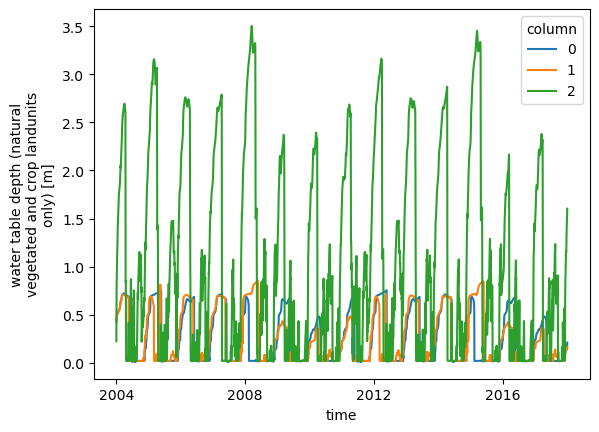

In [29]:
coldata.ZWT.plot.line(x = 'time') 

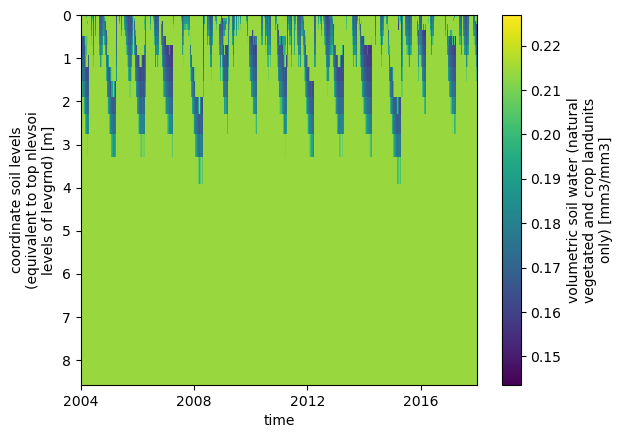

In [30]:
coldata.sel(column = 2).H2OSOI.plot(x = 'time', yincrease = False)

## Absolute Elevation Comparison

(0.0, 365.0)

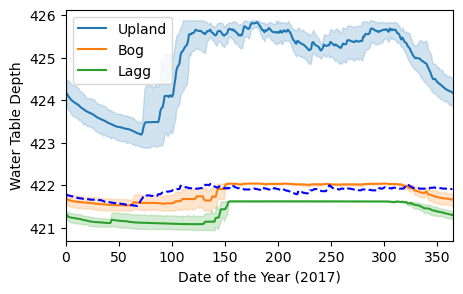

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize = (5, 3))

#Plot CLM hillslope - column level
sns.lineplot(x = Upland.time.dt.dayofyear, y = (upland_elev - Upland.ZWT), label = 'Upland', ax = ax1)
sns.lineplot(x = Bog.time.dt.dayofyear, y = (bog_elev - Bog.ZWT), label = 'Bog', ax = ax1)
sns.lineplot(x = Lagg.time.dt.dayofyear, y = (lagg_elev - Lagg.ZWT), label = 'Lagg', ax = ax1)

#Plot Marcell data 
ax1.plot(wte.WTE, color = 'blue', linestyle = '--', label ='MEF')

#Plot spcifics
ax1.set_xlabel('Date of the Year (2017)')
ax1.set_ylabel('Water Table Depth')
ax1.set_xlim(0, 365)